# Experiments for ER Graph

## Imports

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys

from collections import OrderedDict
import logging
import math

from matplotlib import pyplot as plt
import networkx as nx
import numpy as np

import torch
from torchdiffeq import odeint, odeint_adjoint

sys.path.append('../')

# Baseline imports
from gd_controller import AdjointGD
from dynamics_driver import ForwardKuramotoDynamics, BackwardKuramotoDynamics

# Nodec imports
from neural_net import EluTimeControl, TrainingAlgorithm

# Various Utilities
from utilities import evaluate, calculate_critical_coupling_constant, comparison_plot, state_plot
from nnc.helpers.torch_utils.oscillators import order_parameter_cos

logging.getLogger().setLevel(logging.CRITICAL) # set to info to look at loss values etc.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load graph parameters
Basic setup for calculations, graph, number of nodes, etc.

In [3]:
dtype = torch.float32
device = 'cpu'
graph_type = 'erdos_renyi'
adjacency_matrix = torch.load('../../data/'+graph_type+'_adjacency.pt')
parameters = torch.load('../../data/parameters.pt')
# driver vector is a column vector with 1 value for driver nodes
# and 0 for non drivers.

result_folder = '../../results/' + graph_type + os.path.sep
os.makedirs(result_folder, exist_ok=True)

## Load dynamics parameters
Load natural frequencies and initial states which are common for all graphs and also calculate the coupling constant which is different per graph. We use a coupling constant value that is $10%$ of the critical coupling constant value.

In [4]:
total_time = parameters['total_time']
total_time = 5
natural_frequencies = parameters['natural_frequencies']

critical_coupling_constant = calculate_critical_coupling_constant(adjacency_matrix, natural_frequencies)
coupling_constant = 0.15*critical_coupling_constant
theta_0 = parameters['theta_0']

## NODEC
We now train NODEC with a shallow neural network. We initialize the parameters in a deterministic manner, and use stochastic gradient descent to train it. The learning rate, number of epochs and neural architecture may change per graph. We use different fractions of driver nodes.

In [7]:
fractions = np.linspace(0,1,10)

order_parameter_mean = []
order_parameter_std = []
samples = 1000

for p in fractions:
    sample_arr = []
    for i in range(samples):
        print(p,i)
        driver_nodes = int(p*adjacency_matrix.shape[0])
        driver_vector = torch.zeros([adjacency_matrix.shape[0],1])
        idx = torch.randperm(len(driver_vector))[:driver_nodes]
        driver_vector[idx] = 1

        forward_dynamics = ForwardKuramotoDynamics(adjacency_matrix, 
                                                   driver_vector, 
                                                   coupling_constant, 
                                                   natural_frequencies
                                                  )
        backward_dynamics = BackwardKuramotoDynamics(adjacency_matrix, 
                                                     driver_vector, 
                                                     coupling_constant, 
                                                     natural_frequencies
                                                    )

        neural_net = EluTimeControl([2])
        for parameter in neural_net.parameters():
            parameter.data = torch.ones_like(parameter.data)/1000 # deterministic init!
        train_algo = TrainingAlgorithm(neural_net, forward_dynamics)
        best_model = train_algo.train(theta_0, total_time, epochs=3, lr=0.3)

        control_trajectory, state_trajectory =\
        evaluate(forward_dynamics, theta_0, best_model, total_time, 100)
        nn_control = torch.cat(control_trajectory).squeeze().cpu().detach().numpy()
        nn_states = torch.cat(state_trajectory).cpu().detach().numpy()
        nn_e = (nn_control**2).cumsum(-1)
        nn_r = order_parameter_cos(torch.tensor(nn_states)).cpu().numpy()
        sample_arr.append(nn_r[-1])
    
    order_parameter_mean.append(np.mean(sample_arr))
    order_parameter_std.append(np.std(sample_arr,ddof=1))

0.0 0
0.0 1
0.0 2
0.0 3
0.0 4
0.0 5
0.0 6
0.0 7
0.0 8
0.0 9
0.0 10
0.0 11
0.0 12
0.0 13
0.0 14
0.0 15
0.0 16
0.0 17
0.0 18
0.0 19
0.0 20
0.0 21
0.0 22
0.0 23
0.0 24
0.0 25
0.0 26
0.0 27
0.0 28
0.0 29
0.0 30
0.0 31
0.0 32
0.0 33
0.0 34
0.0 35
0.0 36
0.0 37
0.0 38
0.0 39
0.0 40
0.0 41
0.0 42
0.0 43
0.0 44
0.0 45
0.0 46
0.0 47
0.0 48
0.0 49
0.0 50
0.0 51
0.0 52
0.0 53
0.0 54
0.0 55
0.0 56
0.0 57
0.0 58
0.0 59
0.0 60
0.0 61
0.0 62
0.0 63
0.0 64
0.0 65
0.0 66
0.0 67
0.0 68
0.0 69
0.0 70
0.0 71
0.0 72
0.0 73
0.0 74
0.0 75
0.0 76
0.0 77
0.0 78
0.0 79
0.0 80
0.0 81
0.0 82
0.0 83
0.0 84
0.0 85
0.0 86
0.0 87
0.0 88
0.0 89
0.0 90
0.0 91
0.0 92
0.0 93
0.0 94
0.0 95
0.0 96
0.0 97
0.0 98
0.0 99
0.0 100
0.0 101
0.0 102
0.0 103
0.0 104
0.0 105
0.0 106
0.0 107
0.0 108
0.0 109
0.0 110
0.0 111
0.0 112
0.0 113
0.0 114
0.0 115
0.0 116
0.0 117
0.0 118
0.0 119
0.0 120
0.0 121
0.0 122
0.0 123
0.0 124
0.0 125
0.0 126
0.0 127
0.0 128
0.0 129
0.0 130
0.0 131
0.0 132
0.0 133
0.0 134
0.0 135
0.0 136
0.0 137
0.0 13

0.1111111111111111 15
0.1111111111111111 16
0.1111111111111111 17
0.1111111111111111 18
0.1111111111111111 19
0.1111111111111111 20
0.1111111111111111 21
0.1111111111111111 22
0.1111111111111111 23
0.1111111111111111 24
0.1111111111111111 25
0.1111111111111111 26
0.1111111111111111 27
0.1111111111111111 28
0.1111111111111111 29
0.1111111111111111 30
0.1111111111111111 31
0.1111111111111111 32
0.1111111111111111 33
0.1111111111111111 34
0.1111111111111111 35
0.1111111111111111 36
0.1111111111111111 37
0.1111111111111111 38
0.1111111111111111 39
0.1111111111111111 40
0.1111111111111111 41
0.1111111111111111 42
0.1111111111111111 43
0.1111111111111111 44
0.1111111111111111 45
0.1111111111111111 46
0.1111111111111111 47
0.1111111111111111 48
0.1111111111111111 49
0.1111111111111111 50
0.1111111111111111 51
0.1111111111111111 52
0.1111111111111111 53
0.1111111111111111 54
0.1111111111111111 55
0.1111111111111111 56
0.1111111111111111 57
0.1111111111111111 58
0.1111111111111111 59
0.11111111

0.1111111111111111 375
0.1111111111111111 376
0.1111111111111111 377
0.1111111111111111 378
0.1111111111111111 379
0.1111111111111111 380
0.1111111111111111 381
0.1111111111111111 382
0.1111111111111111 383
0.1111111111111111 384
0.1111111111111111 385
0.1111111111111111 386
0.1111111111111111 387
0.1111111111111111 388
0.1111111111111111 389
0.1111111111111111 390
0.1111111111111111 391
0.1111111111111111 392
0.1111111111111111 393
0.1111111111111111 394
0.1111111111111111 395
0.1111111111111111 396
0.1111111111111111 397
0.1111111111111111 398
0.1111111111111111 399
0.1111111111111111 400
0.1111111111111111 401
0.1111111111111111 402
0.1111111111111111 403
0.1111111111111111 404
0.1111111111111111 405
0.1111111111111111 406
0.1111111111111111 407
0.1111111111111111 408
0.1111111111111111 409
0.1111111111111111 410
0.1111111111111111 411
0.1111111111111111 412
0.1111111111111111 413
0.1111111111111111 414
0.1111111111111111 415
0.1111111111111111 416
0.1111111111111111 417
0.111111111

0.1111111111111111 732
0.1111111111111111 733
0.1111111111111111 734
0.1111111111111111 735
0.1111111111111111 736
0.1111111111111111 737
0.1111111111111111 738
0.1111111111111111 739
0.1111111111111111 740
0.1111111111111111 741
0.1111111111111111 742
0.1111111111111111 743
0.1111111111111111 744
0.1111111111111111 745
0.1111111111111111 746
0.1111111111111111 747
0.1111111111111111 748
0.1111111111111111 749
0.1111111111111111 750
0.1111111111111111 751
0.1111111111111111 752
0.1111111111111111 753
0.1111111111111111 754
0.1111111111111111 755
0.1111111111111111 756
0.1111111111111111 757
0.1111111111111111 758
0.1111111111111111 759
0.1111111111111111 760
0.1111111111111111 761
0.1111111111111111 762
0.1111111111111111 763
0.1111111111111111 764
0.1111111111111111 765
0.1111111111111111 766
0.1111111111111111 767
0.1111111111111111 768
0.1111111111111111 769
0.1111111111111111 770
0.1111111111111111 771
0.1111111111111111 772
0.1111111111111111 773
0.1111111111111111 774
0.111111111

0.2222222222222222 93
0.2222222222222222 94
0.2222222222222222 95
0.2222222222222222 96
0.2222222222222222 97
0.2222222222222222 98
0.2222222222222222 99
0.2222222222222222 100
0.2222222222222222 101
0.2222222222222222 102
0.2222222222222222 103
0.2222222222222222 104
0.2222222222222222 105
0.2222222222222222 106
0.2222222222222222 107
0.2222222222222222 108
0.2222222222222222 109
0.2222222222222222 110
0.2222222222222222 111
0.2222222222222222 112
0.2222222222222222 113
0.2222222222222222 114
0.2222222222222222 115
0.2222222222222222 116
0.2222222222222222 117
0.2222222222222222 118
0.2222222222222222 119
0.2222222222222222 120
0.2222222222222222 121
0.2222222222222222 122
0.2222222222222222 123
0.2222222222222222 124
0.2222222222222222 125
0.2222222222222222 126
0.2222222222222222 127
0.2222222222222222 128
0.2222222222222222 129
0.2222222222222222 130
0.2222222222222222 131
0.2222222222222222 132
0.2222222222222222 133
0.2222222222222222 134
0.2222222222222222 135
0.2222222222222222

0.2222222222222222 450
0.2222222222222222 451
0.2222222222222222 452
0.2222222222222222 453
0.2222222222222222 454
0.2222222222222222 455
0.2222222222222222 456
0.2222222222222222 457
0.2222222222222222 458
0.2222222222222222 459
0.2222222222222222 460
0.2222222222222222 461
0.2222222222222222 462
0.2222222222222222 463
0.2222222222222222 464
0.2222222222222222 465
0.2222222222222222 466
0.2222222222222222 467
0.2222222222222222 468
0.2222222222222222 469
0.2222222222222222 470
0.2222222222222222 471
0.2222222222222222 472
0.2222222222222222 473
0.2222222222222222 474
0.2222222222222222 475
0.2222222222222222 476
0.2222222222222222 477
0.2222222222222222 478
0.2222222222222222 479
0.2222222222222222 480
0.2222222222222222 481
0.2222222222222222 482
0.2222222222222222 483
0.2222222222222222 484
0.2222222222222222 485
0.2222222222222222 486
0.2222222222222222 487
0.2222222222222222 488
0.2222222222222222 489
0.2222222222222222 490
0.2222222222222222 491
0.2222222222222222 492
0.222222222

0.2222222222222222 807
0.2222222222222222 808
0.2222222222222222 809
0.2222222222222222 810
0.2222222222222222 811
0.2222222222222222 812
0.2222222222222222 813
0.2222222222222222 814
0.2222222222222222 815
0.2222222222222222 816
0.2222222222222222 817
0.2222222222222222 818
0.2222222222222222 819
0.2222222222222222 820
0.2222222222222222 821
0.2222222222222222 822
0.2222222222222222 823
0.2222222222222222 824
0.2222222222222222 825
0.2222222222222222 826
0.2222222222222222 827
0.2222222222222222 828
0.2222222222222222 829
0.2222222222222222 830
0.2222222222222222 831
0.2222222222222222 832
0.2222222222222222 833
0.2222222222222222 834
0.2222222222222222 835
0.2222222222222222 836
0.2222222222222222 837
0.2222222222222222 838
0.2222222222222222 839
0.2222222222222222 840
0.2222222222222222 841
0.2222222222222222 842
0.2222222222222222 843
0.2222222222222222 844
0.2222222222222222 845
0.2222222222222222 846
0.2222222222222222 847
0.2222222222222222 848
0.2222222222222222 849
0.222222222

0.3333333333333333 168
0.3333333333333333 169
0.3333333333333333 170
0.3333333333333333 171
0.3333333333333333 172
0.3333333333333333 173
0.3333333333333333 174
0.3333333333333333 175
0.3333333333333333 176
0.3333333333333333 177
0.3333333333333333 178
0.3333333333333333 179
0.3333333333333333 180
0.3333333333333333 181
0.3333333333333333 182
0.3333333333333333 183
0.3333333333333333 184
0.3333333333333333 185
0.3333333333333333 186
0.3333333333333333 187
0.3333333333333333 188
0.3333333333333333 189
0.3333333333333333 190
0.3333333333333333 191
0.3333333333333333 192
0.3333333333333333 193
0.3333333333333333 194
0.3333333333333333 195
0.3333333333333333 196
0.3333333333333333 197
0.3333333333333333 198
0.3333333333333333 199
0.3333333333333333 200
0.3333333333333333 201
0.3333333333333333 202
0.3333333333333333 203
0.3333333333333333 204
0.3333333333333333 205
0.3333333333333333 206
0.3333333333333333 207
0.3333333333333333 208
0.3333333333333333 209
0.3333333333333333 210
0.333333333

0.3333333333333333 525
0.3333333333333333 526
0.3333333333333333 527
0.3333333333333333 528
0.3333333333333333 529
0.3333333333333333 530
0.3333333333333333 531
0.3333333333333333 532
0.3333333333333333 533
0.3333333333333333 534
0.3333333333333333 535
0.3333333333333333 536
0.3333333333333333 537
0.3333333333333333 538
0.3333333333333333 539
0.3333333333333333 540
0.3333333333333333 541
0.3333333333333333 542
0.3333333333333333 543
0.3333333333333333 544
0.3333333333333333 545
0.3333333333333333 546
0.3333333333333333 547
0.3333333333333333 548
0.3333333333333333 549
0.3333333333333333 550
0.3333333333333333 551
0.3333333333333333 552
0.3333333333333333 553
0.3333333333333333 554
0.3333333333333333 555
0.3333333333333333 556
0.3333333333333333 557
0.3333333333333333 558
0.3333333333333333 559
0.3333333333333333 560
0.3333333333333333 561
0.3333333333333333 562
0.3333333333333333 563
0.3333333333333333 564
0.3333333333333333 565
0.3333333333333333 566
0.3333333333333333 567
0.333333333

0.3333333333333333 882
0.3333333333333333 883
0.3333333333333333 884
0.3333333333333333 885
0.3333333333333333 886
0.3333333333333333 887
0.3333333333333333 888
0.3333333333333333 889
0.3333333333333333 890
0.3333333333333333 891
0.3333333333333333 892
0.3333333333333333 893
0.3333333333333333 894
0.3333333333333333 895
0.3333333333333333 896
0.3333333333333333 897
0.3333333333333333 898
0.3333333333333333 899
0.3333333333333333 900
0.3333333333333333 901
0.3333333333333333 902
0.3333333333333333 903
0.3333333333333333 904
0.3333333333333333 905
0.3333333333333333 906
0.3333333333333333 907
0.3333333333333333 908
0.3333333333333333 909
0.3333333333333333 910
0.3333333333333333 911
0.3333333333333333 912
0.3333333333333333 913
0.3333333333333333 914
0.3333333333333333 915
0.3333333333333333 916
0.3333333333333333 917
0.3333333333333333 918
0.3333333333333333 919
0.3333333333333333 920
0.3333333333333333 921
0.3333333333333333 922
0.3333333333333333 923
0.3333333333333333 924
0.333333333

0.4444444444444444 243
0.4444444444444444 244
0.4444444444444444 245
0.4444444444444444 246
0.4444444444444444 247
0.4444444444444444 248
0.4444444444444444 249
0.4444444444444444 250
0.4444444444444444 251
0.4444444444444444 252
0.4444444444444444 253
0.4444444444444444 254
0.4444444444444444 255
0.4444444444444444 256
0.4444444444444444 257
0.4444444444444444 258
0.4444444444444444 259
0.4444444444444444 260
0.4444444444444444 261
0.4444444444444444 262
0.4444444444444444 263
0.4444444444444444 264
0.4444444444444444 265
0.4444444444444444 266
0.4444444444444444 267
0.4444444444444444 268
0.4444444444444444 269
0.4444444444444444 270
0.4444444444444444 271
0.4444444444444444 272
0.4444444444444444 273
0.4444444444444444 274
0.4444444444444444 275
0.4444444444444444 276
0.4444444444444444 277
0.4444444444444444 278
0.4444444444444444 279
0.4444444444444444 280
0.4444444444444444 281
0.4444444444444444 282
0.4444444444444444 283
0.4444444444444444 284
0.4444444444444444 285
0.444444444

0.4444444444444444 600
0.4444444444444444 601
0.4444444444444444 602
0.4444444444444444 603
0.4444444444444444 604
0.4444444444444444 605
0.4444444444444444 606
0.4444444444444444 607
0.4444444444444444 608
0.4444444444444444 609
0.4444444444444444 610
0.4444444444444444 611
0.4444444444444444 612
0.4444444444444444 613
0.4444444444444444 614
0.4444444444444444 615
0.4444444444444444 616
0.4444444444444444 617
0.4444444444444444 618
0.4444444444444444 619
0.4444444444444444 620
0.4444444444444444 621
0.4444444444444444 622
0.4444444444444444 623
0.4444444444444444 624
0.4444444444444444 625
0.4444444444444444 626
0.4444444444444444 627
0.4444444444444444 628
0.4444444444444444 629
0.4444444444444444 630
0.4444444444444444 631
0.4444444444444444 632
0.4444444444444444 633
0.4444444444444444 634
0.4444444444444444 635
0.4444444444444444 636
0.4444444444444444 637
0.4444444444444444 638
0.4444444444444444 639
0.4444444444444444 640
0.4444444444444444 641
0.4444444444444444 642
0.444444444

0.4444444444444444 957
0.4444444444444444 958
0.4444444444444444 959
0.4444444444444444 960
0.4444444444444444 961
0.4444444444444444 962
0.4444444444444444 963
0.4444444444444444 964
0.4444444444444444 965
0.4444444444444444 966
0.4444444444444444 967
0.4444444444444444 968
0.4444444444444444 969
0.4444444444444444 970
0.4444444444444444 971
0.4444444444444444 972
0.4444444444444444 973
0.4444444444444444 974
0.4444444444444444 975
0.4444444444444444 976
0.4444444444444444 977
0.4444444444444444 978
0.4444444444444444 979
0.4444444444444444 980
0.4444444444444444 981
0.4444444444444444 982
0.4444444444444444 983
0.4444444444444444 984
0.4444444444444444 985
0.4444444444444444 986
0.4444444444444444 987
0.4444444444444444 988
0.4444444444444444 989
0.4444444444444444 990
0.4444444444444444 991
0.4444444444444444 992
0.4444444444444444 993
0.4444444444444444 994
0.4444444444444444 995
0.4444444444444444 996
0.4444444444444444 997
0.4444444444444444 998
0.4444444444444444 999
0.555555555

0.5555555555555556 318
0.5555555555555556 319
0.5555555555555556 320
0.5555555555555556 321
0.5555555555555556 322
0.5555555555555556 323
0.5555555555555556 324
0.5555555555555556 325
0.5555555555555556 326
0.5555555555555556 327
0.5555555555555556 328
0.5555555555555556 329
0.5555555555555556 330
0.5555555555555556 331
0.5555555555555556 332
0.5555555555555556 333
0.5555555555555556 334
0.5555555555555556 335
0.5555555555555556 336
0.5555555555555556 337
0.5555555555555556 338
0.5555555555555556 339
0.5555555555555556 340
0.5555555555555556 341
0.5555555555555556 342
0.5555555555555556 343
0.5555555555555556 344
0.5555555555555556 345
0.5555555555555556 346
0.5555555555555556 347
0.5555555555555556 348
0.5555555555555556 349
0.5555555555555556 350
0.5555555555555556 351
0.5555555555555556 352
0.5555555555555556 353
0.5555555555555556 354
0.5555555555555556 355
0.5555555555555556 356
0.5555555555555556 357
0.5555555555555556 358
0.5555555555555556 359
0.5555555555555556 360
0.555555555

0.5555555555555556 675
0.5555555555555556 676
0.5555555555555556 677
0.5555555555555556 678
0.5555555555555556 679
0.5555555555555556 680
0.5555555555555556 681
0.5555555555555556 682
0.5555555555555556 683
0.5555555555555556 684
0.5555555555555556 685
0.5555555555555556 686
0.5555555555555556 687
0.5555555555555556 688
0.5555555555555556 689
0.5555555555555556 690
0.5555555555555556 691
0.5555555555555556 692
0.5555555555555556 693
0.5555555555555556 694
0.5555555555555556 695
0.5555555555555556 696
0.5555555555555556 697
0.5555555555555556 698
0.5555555555555556 699
0.5555555555555556 700
0.5555555555555556 701
0.5555555555555556 702
0.5555555555555556 703
0.5555555555555556 704
0.5555555555555556 705
0.5555555555555556 706
0.5555555555555556 707
0.5555555555555556 708
0.5555555555555556 709
0.5555555555555556 710
0.5555555555555556 711
0.5555555555555556 712
0.5555555555555556 713
0.5555555555555556 714
0.5555555555555556 715
0.5555555555555556 716
0.5555555555555556 717
0.555555555

0.6666666666666666 34
0.6666666666666666 35
0.6666666666666666 36
0.6666666666666666 37
0.6666666666666666 38
0.6666666666666666 39
0.6666666666666666 40
0.6666666666666666 41
0.6666666666666666 42
0.6666666666666666 43
0.6666666666666666 44
0.6666666666666666 45
0.6666666666666666 46
0.6666666666666666 47
0.6666666666666666 48
0.6666666666666666 49
0.6666666666666666 50
0.6666666666666666 51
0.6666666666666666 52
0.6666666666666666 53
0.6666666666666666 54
0.6666666666666666 55
0.6666666666666666 56
0.6666666666666666 57
0.6666666666666666 58
0.6666666666666666 59
0.6666666666666666 60
0.6666666666666666 61
0.6666666666666666 62
0.6666666666666666 63
0.6666666666666666 64
0.6666666666666666 65
0.6666666666666666 66
0.6666666666666666 67
0.6666666666666666 68
0.6666666666666666 69
0.6666666666666666 70
0.6666666666666666 71
0.6666666666666666 72
0.6666666666666666 73
0.6666666666666666 74
0.6666666666666666 75
0.6666666666666666 76
0.6666666666666666 77
0.6666666666666666 78
0.66666666

0.6666666666666666 394
0.6666666666666666 395
0.6666666666666666 396
0.6666666666666666 397
0.6666666666666666 398
0.6666666666666666 399
0.6666666666666666 400
0.6666666666666666 401
0.6666666666666666 402
0.6666666666666666 403
0.6666666666666666 404
0.6666666666666666 405
0.6666666666666666 406
0.6666666666666666 407
0.6666666666666666 408
0.6666666666666666 409
0.6666666666666666 410
0.6666666666666666 411
0.6666666666666666 412
0.6666666666666666 413
0.6666666666666666 414
0.6666666666666666 415
0.6666666666666666 416
0.6666666666666666 417
0.6666666666666666 418
0.6666666666666666 419
0.6666666666666666 420
0.6666666666666666 421
0.6666666666666666 422
0.6666666666666666 423
0.6666666666666666 424
0.6666666666666666 425
0.6666666666666666 426
0.6666666666666666 427
0.6666666666666666 428
0.6666666666666666 429
0.6666666666666666 430
0.6666666666666666 431
0.6666666666666666 432
0.6666666666666666 433
0.6666666666666666 434
0.6666666666666666 435
0.6666666666666666 436
0.666666666

0.6666666666666666 751
0.6666666666666666 752
0.6666666666666666 753
0.6666666666666666 754
0.6666666666666666 755
0.6666666666666666 756
0.6666666666666666 757
0.6666666666666666 758
0.6666666666666666 759
0.6666666666666666 760
0.6666666666666666 761
0.6666666666666666 762
0.6666666666666666 763
0.6666666666666666 764
0.6666666666666666 765
0.6666666666666666 766
0.6666666666666666 767
0.6666666666666666 768
0.6666666666666666 769
0.6666666666666666 770
0.6666666666666666 771
0.6666666666666666 772
0.6666666666666666 773
0.6666666666666666 774
0.6666666666666666 775
0.6666666666666666 776
0.6666666666666666 777
0.6666666666666666 778
0.6666666666666666 779
0.6666666666666666 780
0.6666666666666666 781
0.6666666666666666 782
0.6666666666666666 783
0.6666666666666666 784
0.6666666666666666 785
0.6666666666666666 786
0.6666666666666666 787
0.6666666666666666 788
0.6666666666666666 789
0.6666666666666666 790
0.6666666666666666 791
0.6666666666666666 792
0.6666666666666666 793
0.666666666

0.7777777777777777 112
0.7777777777777777 113
0.7777777777777777 114
0.7777777777777777 115
0.7777777777777777 116
0.7777777777777777 117
0.7777777777777777 118
0.7777777777777777 119
0.7777777777777777 120
0.7777777777777777 121
0.7777777777777777 122
0.7777777777777777 123
0.7777777777777777 124
0.7777777777777777 125
0.7777777777777777 126
0.7777777777777777 127
0.7777777777777777 128
0.7777777777777777 129
0.7777777777777777 130
0.7777777777777777 131
0.7777777777777777 132
0.7777777777777777 133
0.7777777777777777 134
0.7777777777777777 135
0.7777777777777777 136
0.7777777777777777 137
0.7777777777777777 138
0.7777777777777777 139
0.7777777777777777 140
0.7777777777777777 141
0.7777777777777777 142
0.7777777777777777 143
0.7777777777777777 144
0.7777777777777777 145
0.7777777777777777 146
0.7777777777777777 147
0.7777777777777777 148
0.7777777777777777 149
0.7777777777777777 150
0.7777777777777777 151
0.7777777777777777 152
0.7777777777777777 153
0.7777777777777777 154
0.777777777

0.7777777777777777 469
0.7777777777777777 470
0.7777777777777777 471
0.7777777777777777 472
0.7777777777777777 473
0.7777777777777777 474
0.7777777777777777 475
0.7777777777777777 476
0.7777777777777777 477
0.7777777777777777 478
0.7777777777777777 479
0.7777777777777777 480
0.7777777777777777 481
0.7777777777777777 482
0.7777777777777777 483
0.7777777777777777 484
0.7777777777777777 485
0.7777777777777777 486
0.7777777777777777 487
0.7777777777777777 488
0.7777777777777777 489
0.7777777777777777 490
0.7777777777777777 491
0.7777777777777777 492
0.7777777777777777 493
0.7777777777777777 494
0.7777777777777777 495
0.7777777777777777 496
0.7777777777777777 497
0.7777777777777777 498
0.7777777777777777 499
0.7777777777777777 500
0.7777777777777777 501
0.7777777777777777 502
0.7777777777777777 503
0.7777777777777777 504
0.7777777777777777 505
0.7777777777777777 506
0.7777777777777777 507
0.7777777777777777 508
0.7777777777777777 509
0.7777777777777777 510
0.7777777777777777 511
0.777777777

0.7777777777777777 826
0.7777777777777777 827
0.7777777777777777 828
0.7777777777777777 829
0.7777777777777777 830
0.7777777777777777 831
0.7777777777777777 832
0.7777777777777777 833
0.7777777777777777 834
0.7777777777777777 835
0.7777777777777777 836
0.7777777777777777 837
0.7777777777777777 838
0.7777777777777777 839
0.7777777777777777 840
0.7777777777777777 841
0.7777777777777777 842
0.7777777777777777 843
0.7777777777777777 844
0.7777777777777777 845
0.7777777777777777 846
0.7777777777777777 847
0.7777777777777777 848
0.7777777777777777 849
0.7777777777777777 850
0.7777777777777777 851
0.7777777777777777 852
0.7777777777777777 853
0.7777777777777777 854
0.7777777777777777 855
0.7777777777777777 856
0.7777777777777777 857
0.7777777777777777 858
0.7777777777777777 859
0.7777777777777777 860
0.7777777777777777 861
0.7777777777777777 862
0.7777777777777777 863
0.7777777777777777 864
0.7777777777777777 865
0.7777777777777777 866
0.7777777777777777 867
0.7777777777777777 868
0.777777777

0.8888888888888888 187
0.8888888888888888 188
0.8888888888888888 189
0.8888888888888888 190
0.8888888888888888 191
0.8888888888888888 192
0.8888888888888888 193
0.8888888888888888 194
0.8888888888888888 195
0.8888888888888888 196
0.8888888888888888 197
0.8888888888888888 198
0.8888888888888888 199
0.8888888888888888 200
0.8888888888888888 201
0.8888888888888888 202
0.8888888888888888 203
0.8888888888888888 204
0.8888888888888888 205
0.8888888888888888 206
0.8888888888888888 207
0.8888888888888888 208
0.8888888888888888 209
0.8888888888888888 210
0.8888888888888888 211
0.8888888888888888 212
0.8888888888888888 213
0.8888888888888888 214
0.8888888888888888 215
0.8888888888888888 216
0.8888888888888888 217
0.8888888888888888 218
0.8888888888888888 219
0.8888888888888888 220
0.8888888888888888 221
0.8888888888888888 222
0.8888888888888888 223
0.8888888888888888 224
0.8888888888888888 225
0.8888888888888888 226
0.8888888888888888 227
0.8888888888888888 228
0.8888888888888888 229
0.888888888

0.8888888888888888 544
0.8888888888888888 545
0.8888888888888888 546
0.8888888888888888 547
0.8888888888888888 548
0.8888888888888888 549
0.8888888888888888 550
0.8888888888888888 551
0.8888888888888888 552
0.8888888888888888 553
0.8888888888888888 554
0.8888888888888888 555
0.8888888888888888 556
0.8888888888888888 557
0.8888888888888888 558
0.8888888888888888 559
0.8888888888888888 560
0.8888888888888888 561
0.8888888888888888 562
0.8888888888888888 563
0.8888888888888888 564
0.8888888888888888 565
0.8888888888888888 566
0.8888888888888888 567
0.8888888888888888 568
0.8888888888888888 569
0.8888888888888888 570
0.8888888888888888 571
0.8888888888888888 572
0.8888888888888888 573
0.8888888888888888 574
0.8888888888888888 575
0.8888888888888888 576
0.8888888888888888 577
0.8888888888888888 578
0.8888888888888888 579
0.8888888888888888 580
0.8888888888888888 581
0.8888888888888888 582
0.8888888888888888 583
0.8888888888888888 584
0.8888888888888888 585
0.8888888888888888 586
0.888888888

0.8888888888888888 901
0.8888888888888888 902
0.8888888888888888 903
0.8888888888888888 904
0.8888888888888888 905
0.8888888888888888 906
0.8888888888888888 907
0.8888888888888888 908
0.8888888888888888 909
0.8888888888888888 910
0.8888888888888888 911
0.8888888888888888 912
0.8888888888888888 913
0.8888888888888888 914
0.8888888888888888 915
0.8888888888888888 916
0.8888888888888888 917
0.8888888888888888 918
0.8888888888888888 919
0.8888888888888888 920
0.8888888888888888 921
0.8888888888888888 922
0.8888888888888888 923
0.8888888888888888 924
0.8888888888888888 925
0.8888888888888888 926
0.8888888888888888 927
0.8888888888888888 928
0.8888888888888888 929
0.8888888888888888 930
0.8888888888888888 931
0.8888888888888888 932
0.8888888888888888 933
0.8888888888888888 934
0.8888888888888888 935
0.8888888888888888 936
0.8888888888888888 937
0.8888888888888888 938
0.8888888888888888 939
0.8888888888888888 940
0.8888888888888888 941
0.8888888888888888 942
0.8888888888888888 943
0.888888888

1.0 754
1.0 755
1.0 756
1.0 757
1.0 758
1.0 759
1.0 760
1.0 761
1.0 762
1.0 763
1.0 764
1.0 765
1.0 766
1.0 767
1.0 768
1.0 769
1.0 770
1.0 771
1.0 772
1.0 773
1.0 774
1.0 775
1.0 776
1.0 777
1.0 778
1.0 779
1.0 780
1.0 781
1.0 782
1.0 783
1.0 784
1.0 785
1.0 786
1.0 787
1.0 788
1.0 789
1.0 790
1.0 791
1.0 792
1.0 793
1.0 794
1.0 795
1.0 796
1.0 797
1.0 798
1.0 799
1.0 800
1.0 801
1.0 802
1.0 803
1.0 804
1.0 805
1.0 806
1.0 807
1.0 808
1.0 809
1.0 810
1.0 811
1.0 812
1.0 813
1.0 814
1.0 815
1.0 816
1.0 817
1.0 818
1.0 819
1.0 820
1.0 821
1.0 822
1.0 823
1.0 824
1.0 825
1.0 826
1.0 827
1.0 828
1.0 829
1.0 830
1.0 831
1.0 832
1.0 833
1.0 834
1.0 835
1.0 836
1.0 837
1.0 838
1.0 839
1.0 840
1.0 841
1.0 842
1.0 843
1.0 844
1.0 845
1.0 846
1.0 847
1.0 848
1.0 849
1.0 850
1.0 851
1.0 852
1.0 853
1.0 854
1.0 855
1.0 856
1.0 857
1.0 858
1.0 859
1.0 860
1.0 861
1.0 862
1.0 863
1.0 864
1.0 865
1.0 866
1.0 867
1.0 868
1.0 869
1.0 870
1.0 871
1.0 872
1.0 873
1.0 874
1.0 875
1.0 876
1.0 877
1.0 878


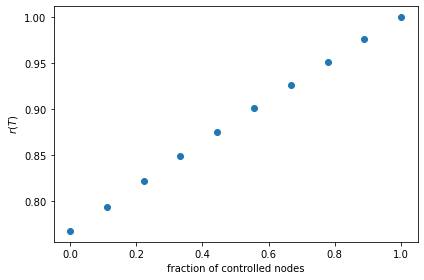

In [8]:
order_parameter_mean = np.array(order_parameter_mean)
order_parameter_std = np.array(order_parameter_std)

plt.figure()
plt.errorbar(fractions,order_parameter_mean,yerr=order_parameter_std/np.sqrt(samples),fmt="o")
plt.xlabel(r"fraction of controlled nodes")
plt.ylabel(r"$r(T)$")
plt.tight_layout()
plt.show()

In [9]:
np.savetxt("ER_drivers_K015.csv",np.c_[order_parameter_mean,order_parameter_std],header="order parameter mean\t order parameter std")